In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.preprocessing import MinMaxScaler

# 1. Prepare data for modeling

In [2]:
model_df = pd.read_csv('model_dataset/labeled_processed_data.csv')
model_df['class'] = 'none'
model_df.loc[model_df['scratch'] == 1, 'class'] = 'scratch'
model_df.loc[model_df['focus_spot'] == 1, 'class'] = 'focus_spot'
model_df.drop(columns=['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID',
                       'c_id', 'none', 'scratch', 'focus_spot'], inplace=True)

# Split data into test, training, and validation sets
X = model_df.drop(columns='class')
y = model_df['class']
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.3,
                                                    random_state=11)

X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val,
                                                    stratify=y_test_val, 
                                                    test_size=0.5,
                                                    random_state=11)

# Scale data to be between 1 and 0
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

# 2. Hyperparameter tuning for KNN

In [9]:
# Determine optimal K neighbors (using elbow method)
acc_score_list = []
for n in range(1, 20):
    
    # Initialize, fit, and predict using knn
    clf = knn(n_neighbors=n, weights='distance')
    clf.fit(X_train_scaled, y_train)
    y_val_pred = clf.predict(X_val_scaled)
    
    # Record and collect accuracy score
    acc_score_list.append(
        [n, balanced_accuracy_score(y_val, y_val_pred)])

# Plot accuracy score
acc_score_df = pd.DataFrame(acc_score_list, 
                           columns=['Number of Neighbors', 'Accuracy Score'])
plt.style.use('fivethirtyeight')
sns.lineplot(x='Number of Neighbors', y='Accuracy Score', data=acc_score_df)
plt.show()

# 3. Evaluate KNN with chosen hyperparameter

              precision    recall  f1-score   support

  focus_spot       0.58      0.58      0.58       144
        none       0.89      0.88      0.88       505
     scratch       0.22      0.24      0.23        34

    accuracy                           0.79       683
   macro avg       0.56      0.56      0.56       683
weighted avg       0.79      0.79      0.79       683



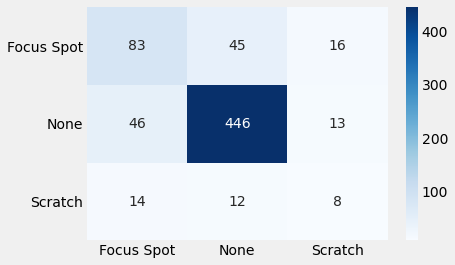

In [14]:
# Set model hyperparameters (K = 1)
clf = knn(n_neighbors=1, weights='distance')
clf.fit(X_train_scaled, y_train)
y_test_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_test_pred))
cf_matrix = confusion_matrix(y_test, y_test_pred)
labels = np.asarray(cf_matrix.flatten()).reshape(3,3)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',
            xticklabels=['Focus Spot', 'None', 'Scratch'],
            yticklabels=['Focus Spot', 'None', 'Scratch'])
plt.yticks(rotation=0)
plt.show()